In [1]:
import pandas   as pd             # dataframe
import seaborn  as sns            # plots
import matplotlib.pyplot as plt   # plots
import yfinance as yf         # import Yahoo! Finance
import os

In [2]:
def LoadData(ticker):
    filename = ticker.replace("^", "")
    if os.path.exists(f"data/{filename}.csv"):
        df = pd.read_csv(f"data/{filename}.csv", index_col='Date', parse_dates=True)
    else:
        df = yf.download(ticker, period="max")
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        df.to_csv(f"data/{filename}.csv")
    return df

In [3]:
#AEX ^AEX
#BEL20 ^BFX
#DJIA ^DJI
#S&P500 ^GSPC
#Nikkei ^N225
#MSCI World Index ETF SPYI.DE
indices = {'BEL20':'^BFX','AEX':'^AEX', 'DJIA':'^DJI','S&P500':'^GSPC','Euro Stoxx 50':'^STOXX50E','MSCI World ETF':'SPYI.DE'}
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,2024]

# Dictionary to store the yearly returns
yearly_returns = pd.DataFrame()


In [4]:
def getfirsttradingdate(year):
        return pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='B').min()

def getlasttradingdate(year):
        return pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='B').max()

In [5]:
# Loop through each index and calculate the yearly returns
for name, ticker in indices.items():
    
    for year in years:
      # Download the data
      data = LoadData(ticker)
      data = data[(data.index >= getfirsttradingdate(year)) & (data.index <= getlasttradingdate(year))]
      yearly_return = (data["Close"].iloc[-1] / data["Close"].iloc[0]) - 1
      #print(f"Yearly return for {ticker} in {year}: {yearly_return}")
      new_row = pd.DataFrame([{'Ticker': ticker, 'Year': year, 'Yearly Return': yearly_return}])
      yearly_returns = pd.concat([yearly_returns, new_row], ignore_index=True)
 


In [6]:
print(yearly_returns)

     Ticker  Year  Yearly Return
0      ^BFX  2013       0.162428
1      ^BFX  2014       0.140537
2      ^BFX  2015       0.137862
3      ^BFX  2016      -0.010001
4      ^BFX  2017       0.087729
..      ...   ...            ...
67  SPYI.DE  2020       0.051449
68  SPYI.DE  2021       0.284200
69  SPYI.DE  2022      -0.129962
70  SPYI.DE  2023       0.153970
71  SPYI.DE  2024       0.229698

[72 rows x 3 columns]


In [7]:
# Create a mapping from ticker to index name
ticker_to_name = {v: k for k, v in indices.items()}

# Add a 'Title' column using the mapping
yearly_returns['Title'] = yearly_returns['Ticker'].map(ticker_to_name)

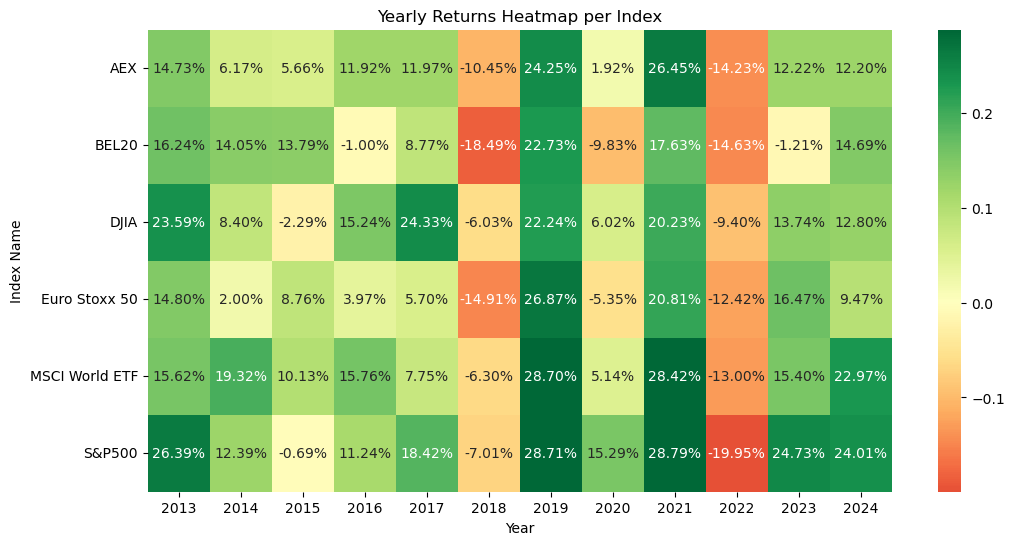

In [8]:
# Pivot the dataframe to have indices as rows and years as columns
pivot_returns = yearly_returns.pivot(index='Title', columns='Year', values='Yearly Return')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_returns, annot=True, fmt=".2%", cmap="RdYlGn", center=0)
plt.title("Yearly Returns Heatmap per Index")
plt.ylabel("Index Name")
plt.xlabel("Year")
plt.show()

In [25]:
def calculate_return_ytd(df, price_col="Close"):
    """
    Calculate year-to-date returns for a price series.
    Assumes df index is datetime and sorted ascending.
    Returns a dictionary with the returns as decimals (e.g., 0.12 for 12%).
    """
    today = df.index.max()
    results = {}

    # Year-to-date (YTD)
    ytd_start = pd.Timestamp(year=today.year, month=1, day=1)
    if ytd_start in df.index:
        ytd_price_start = df.loc[ytd_start, price_col]
    else:
        ytd_idx = df.index.get_indexer([ytd_start], method='bfill')[0]
        ytd_price_start = df.iloc[ytd_idx][price_col]
    ytd_return = (df.loc[today, price_col] / ytd_price_start) - 1
    return ytd_return



In [28]:
def calculate_return_nbrofyears(df, price_col="Close", nbrofyears=1):
    """
    Calculate 1-year return for a price series.
    Assumes df index is datetime and sorted ascending.
    Returns the return as a decimal (e.g., 0.12 for 12%).
    """
    today = df.index.max()
    nbr_years_ago = today - pd.DateOffset(years=nbrofyears)
    nbr_years_ago_idx = df.index.get_indexer([nbr_years_ago], method='bfill')[0]
    nbr_years_ago = df.index[nbr_years_ago_idx]
    year_return = (df.loc[today, price_col] / df.loc[nbr_years_ago, price_col]) - 1
    return year_return

In [30]:
spyidata = LoadData('SPYI.DE')
spyidata = spyidata.sort_index()
spyidata.tail()
print("YTD Return:", f"{round(calculate_return_ytd(spyidata)*100,2)} %")
print("1Y Return:", f"{round(calculate_return_nbrofyears(spyidata, nbrofyears=1)*100,2)} %")
print("5Y Return:", f"{round(calculate_return_nbrofyears(spyidata, nbrofyears=5)*100,2)} %")
print("10Y Return:", f"{round(calculate_return_nbrofyears(spyidata, nbrofyears=10)*100,2)} %")

YTD Return: 0.67 %
1Y Return: 13.3 %
5Y Return: 81.94 %
10Y Return: 168.6 %
